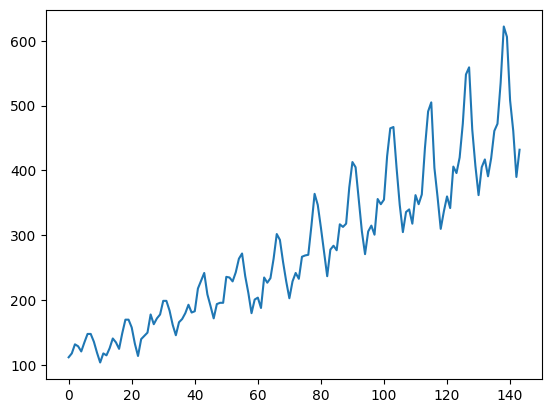

<class 'numpy.ndarray'>


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
 
df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
 
plt.plot(timeseries)
plt.show()

print(type(timeseries))

In [3]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]


In [4]:
import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [5]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1, 1])


/tmp/ipykernel_34341/2861746758.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X), torch.tensor(y)


In [6]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [7]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 226.3080, test RMSE 422.7336
Epoch 100: train RMSE 189.7485, test RMSE 384.5163
Epoch 200: train RMSE 158.7180, test RMSE 351.2488
Epoch 300: train RMSE 131.8371, test RMSE 321.1877
Epoch 400: train RMSE 108.7906, test RMSE 293.4179
Epoch 500: train RMSE 90.4402, test RMSE 268.2729
Epoch 600: train RMSE 74.2026, test RMSE 244.3995
Epoch 700: train RMSE 60.5589, test RMSE 221.7309
Epoch 800: train RMSE 49.9677, test RMSE 201.0818
Epoch 900: train RMSE 41.8175, test RMSE 182.3449
Epoch 1000: train RMSE 35.7712, test RMSE 165.9989
Epoch 1100: train RMSE 31.8538, test RMSE 151.9008
Epoch 1200: train RMSE 28.6780, test RMSE 139.9374
Epoch 1300: train RMSE 26.9052, test RMSE 130.4655
Epoch 1400: train RMSE 26.7503, test RMSE 122.4086
Epoch 1500: train RMSE 24.9396, test RMSE 117.1785
Epoch 1600: train RMSE 24.6238, test RMSE 111.7563
Epoch 1700: train RMSE 24.2724, test RMSE 108.3600
Epoch 1800: train RMSE 23.7911, test RMSE 104.6830
Epoch 1900: train RMSE 23.9707, test R

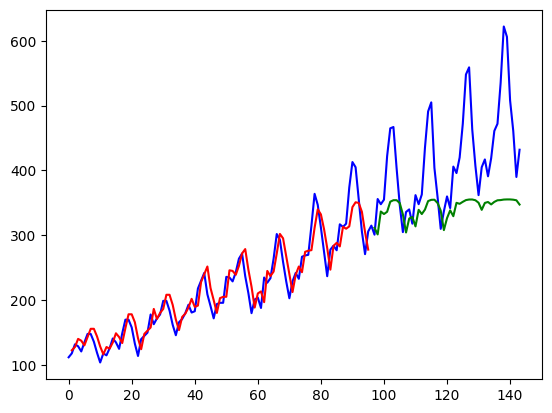

In [8]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()